In [20]:
from IPython.display import display
import cv2
from glob import glob
import os
import random
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import glob
import xml.etree.ElementTree as etree
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.vgg19 import VGG19
import tensorflow as tf

IMAGE_SIZE = 224

base_dir = './datasets/'
images_folder = base_dir + "images/"
annotations_folder = base_dir + "annotations/"

print("Images directory exists:", os.path.exists(images_folder))
print("Annotations directory exists:", os.path.exists(annotations_folder))

print(os.listdir(images_folder)[:1]) 
print(os.listdir(annotations_folder)[:1]) 

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.__version__)

Images directory exists: True
Annotations directory exists: True
['Cars113.png']
['Cars239.xml']
Num GPUs Available:  1
2.14.0


In [3]:
def resize_parse(xml):
    tree = etree.parse(xml)
    root = tree.getroot()
    
    xmax = xmin = ymax = ymin = 0

    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    for object in root.iter('object'):
        bndbox = object.find('bndbox')
        xmin = int(bndbox.find("xmin").text) / (width/IMAGE_SIZE)
        ymin = int(bndbox.find("ymin").text) / (height/IMAGE_SIZE)
        xmax = int(bndbox.find("xmax").text) / (width/IMAGE_SIZE)
        ymax = int(bndbox.find("ymax").text) / (height/IMAGE_SIZE)
        
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

labels = resize_parse('./datasets/annotations/Cars0.xml')
print(labels)

[187, 144, 101, 104]


In [4]:
image_files = sorted(glob.glob(os.path.join(images_folder, '*.png')))
annotation_files = sorted(glob.glob(os.path.join(annotations_folder, '*.xml')))

data_array=[]
for file in image_files:
    img = cv2.imread(file)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    data_array.append(np.array(img))

annotation_array=[]
for file in annotation_files:
    annotation_array.append(np.array(resize_parse(file)))

data_array = np.array(data_array)
annotation_array = np.array(annotation_array)

In [5]:
data_array = data_array / 255
annotation_array = annotation_array / 255

In [6]:
train_images, test_images, train_annotations, test_annotations = train_test_split(data_array, annotation_array, test_size=0.2, random_state=42)
train_images, val_images, train_annotations, val_annotations = train_test_split(train_images, train_annotations, test_size=0.2, random_state=42)

num_split = {
    'train_images': len(train_images),
    'val_images': len(val_images),
    'test_images': len(test_images),
    'train_annotations': len(train_annotations),
    'val_annotations': len(val_annotations),
    'test_annotations': len(test_annotations)
}
display(num_split)

{'train_images': 276,
 'val_images': 70,
 'test_images': 87,
 'train_annotations': 276,
 'val_annotations': 70,
 'test_annotations': 87}

In [8]:
model = Sequential()
model.add(VGG19(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               3211392   
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 4)                 260       
                                                                 
Total params: 23260804 (88.73 MB)
Trainable params: 32

In [9]:
train = model.fit(train_images, train_annotations, validation_data=(val_images, val_annotations), epochs=100, batch_size=4, verbose=1)

Epoch 1/100


2024-04-07 20:30:55.998081: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-04-07 20:30:57.795121: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f58a6d28d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-07 20:30:57.795159: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-04-07 20:30:57.800652: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-07 20:30:57.879735: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


69/69 [==============================] - 5s 34ms/step - loss: 0.0363 - accuracy: 0.5399 - val_loss: 0.0231 - val_accuracy: 0.6286
Epoch 2/100
69/69 [==============================] - 2s 31ms/step - loss: 0.0137 - accuracy: 0.6667 - val_loss: 0.0127 - val_accuracy: 0.7000
Epoch 3/100
69/69 [==============================] - 2s 29ms/step - loss: 0.0070 - accuracy: 0.7536 - val_loss: 0.0082 - val_accuracy: 0.7714
Epoch 4/100
69/69 [==============================] - 2s 28ms/step - loss: 0.0038 - accuracy: 0.8152 - val_loss: 0.0070 - val_accuracy: 0.8143
Epoch 5/100
69/69 [==============================] - 2s 29ms/step - loss: 0.0026 - accuracy: 0.8841 - val_loss: 0.0072 - val_accuracy: 0.8714
Epoch 6/100
69/69 [==============================] - 2s 25ms/step - loss: 0.0022 - accuracy: 0.8696 - val_loss: 0.0068 - val_accuracy: 0.8000
Epoch 7/100
69/69 [==============================] - 2s 26ms/step - loss: 0.0017 - accuracy: 0.8986 - val_loss: 0.0062 - val_accuracy: 0.8714
Epoch 8/100
69/69 

In [10]:
model.save('my_model.h5', overwrite=True) 

/home/johnny/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
scores = model.evaluate(test_images, test_annotations, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 81.61%


In [12]:
history_df = pd.DataFrame(train.history)

# Save to CSV
history_df.to_csv('./training_results.csv', index=False)
    
history_df = pd.DataFrame(train.history)

history_csv_file = './training_history.csv'
with open(history_csv_file, mode='w') as f:
    history_df.to_csv(f)

print(f"Training history saved to {history_csv_file}")

history_df = pd.DataFrame(train.history)
history_csv_file = './training_history.csv'

# Save the DataFrame to a CSV file
history_df.to_csv(history_csv_file, index=False)


Training history saved to ./training_history.csv


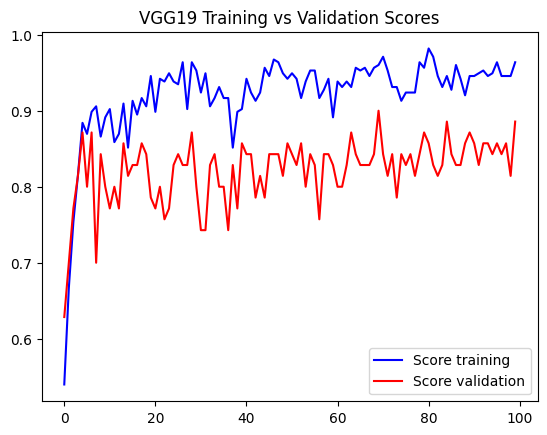

In [19]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score training')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('VGG19 Training vs Validation Scores')
    plt.legend()
    plt.show()

plot_scores(train)

In [14]:
test_loss, test_accuracy = model.evaluate(test_images, test_annotations,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

100/100 [==============================] - 1s 8ms/step - loss: 0.0051 - accuracy: 0.8161
Test results 
 Loss: 0.005145604722201824 
 Accuracy 0.8160919547080994


In [15]:
y_cnn = model.predict(test_images)

3/3 [==============================] - 1s 180ms/step


[48, 42, 29, 21, 49, 73, 36, 70, 35]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


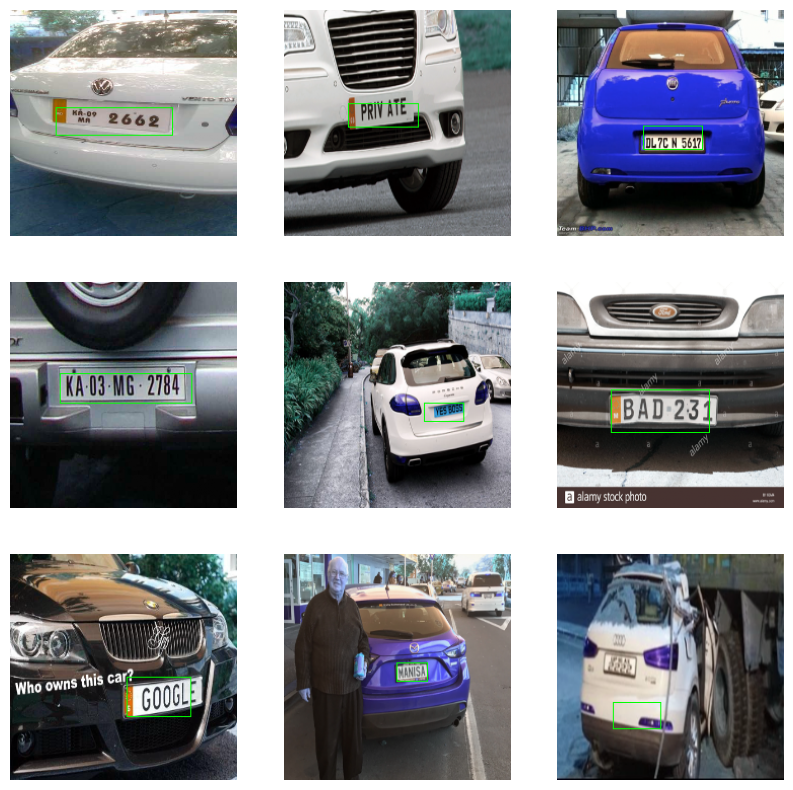

In [34]:
random.seed(41)
indices = random.sample(range(0, len(test_images) - 1), 9)
display(indices)

plt.figure(figsize=(10,10))
for index, i in enumerate(indices):
    plt.subplot(3,3,index+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(test_images[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)